In [3]:
# packages to import: xmitgcm, matplotlib, numpy, os, sys, ecco_v4_py, pandas, warnings, pyTMD (remember to install it!), datetime, xarray
# EXPLANATION OF MOST OF THIS FILE CAN BE FOUND IN TIDAL_ANALYSIS: here we have applied the method developed there to different points listed below
# - English sea point --> tile = 2, i = 31, j = 49
# - New Zeland sea point --> tile = 8, i = 62, j = 30
# - Fundy bay point --> tile = 10, i = 21, j = 58
# THE COMMENTS ARE ONLY ON THE ADDED PART
from xmitgcm import open_mdsdataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from os.path import expanduser,join,isdir
import sys
user_home_dir = expanduser('~')
ecco_v4_py_dir = join(user_home_dir,'ECCOv4-py')
if isdir(ecco_v4_py_dir):
    sys.path.insert(0,ecco_v4_py_dir)
from ecco_v4_py import plot_proj_to_latlon_grid
import ecco_v4_py as ecco
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
import xarray as xr
import pyTMD.crs
import pyTMD.io
import pyTMD.tools
from pyTMD.solve import constants
import pyTMD

In [4]:
data_dir ='/efs_ecco/hvanderz/export_tides'
grid_dir ='/efs_ecco/hvanderz/r5/WORKINGDIR/ECCOV4/release5_ToTs/run'
ds = open_mdsdataset(data_dir, 
                        grid_dir=grid_dir, 
                         prefix={'ETAN'},
                         geometry="llc") 

ds = ds.rename({'face':'tile'})

In [5]:
ds['time'] = xr.cftime_range(start='1992-01-01T13:00:00', periods=ds.dims['time'], freq='h')

In [6]:
ds = ds.unify_chunks()

In [7]:
ds_clm = ds.groupby('time.month').mean('time')
ds_anom = ds.groupby('time.month') - ds_clm

In [8]:
n_files = len(ds_anom.time)             
start_time = '1992-01-01 13:00:00'    
freq = 'h'                  
time_eta = pd.date_range(start=start_time, periods=n_files, freq=freq)

In [9]:
epoch = datetime(1992, 1, 1, 0, 0, 0) 
t = np.array([(ti.to_pydatetime() - epoch).total_seconds() / 86400.0 for ti in time_eta])

In [10]:
constituents = ['m2', 's2', 'n2', 'k2','k1', 'o1', 'p1', 'q1', 'mm', 'mf', 'm4', 'mn4', 'ms4', '2n2']

In [11]:
model_list = sorted(pyTMD.io.model.ocean_elevation())
TMDwidgets = pyTMD.tools.widgets()
TMDwidgets.model.options = model_list
TMDwidgets.model.value = 'TPXO9.1'
TMDwidgets.VBox([
    TMDwidgets.directory,
    TMDwidgets.model,
    TMDwidgets.compress
])
#our directory is /efs_ecco/hvanderz/TMD

In [14]:
start_time_tpxo = '1992-01-01 00:00:00'     
time_eta_tpxo = pd.date_range(start=start_time_tpxo, periods=n_files, freq=freq)

In [15]:
epoch_tpxo = datetime(1992, 1, 1, 0, 0, 0)
t_tpxo = np.array([(ti.to_pydatetime() - epoch_tpxo).total_seconds() / 86400.0 for ti in time_eta_tpxo])

In [16]:
model = pyTMD.io.model(TMDwidgets.directory.value,
    compressed=TMDwidgets.compress.value
   ).elevation(TMDwidgets.model.value)

In [17]:
# Creation of a DataArray with the files of maps of M2 amplitude
file_pattern = "/efs_ecco/hplombat/Hugo_tidal_maps/maps_tmd_1year/amp_M2_{}.txt" # path where the files of maps of M2 amplitude are stored
n_tiles = 13
tile_data = []

for tile in range(n_tiles):
    filename = file_pattern.format(tile)
    data = np.loadtxt(filename)
    tile_data.append(data)

stacked_array = np.stack(tile_data, axis=0)

da = xr.DataArray(
    stacked_array,
    dims=["tile", "j", "i"],
    coords={
        "tile": np.arange(n_tiles),
        "i": np.arange(90),
        "j": np.arange(90)
    },
    name="amplitude"
)

# ENGLISH CHANNEL

In [14]:
ht_mod = ds_anom.isel(tile=2, i=31, j=49).ETAN.values

In [60]:
# for the evaluation of constituents in TPXO model you need lat and lon of the point you are studying so here we are evaluating them
lon = ds_anom.isel(tile=2, i=31, j=49).XC.values
lat = ds_anom.isel(tile=2, i=31, j=49).YC.values
print(lat, lon)

51.00068 -6.5


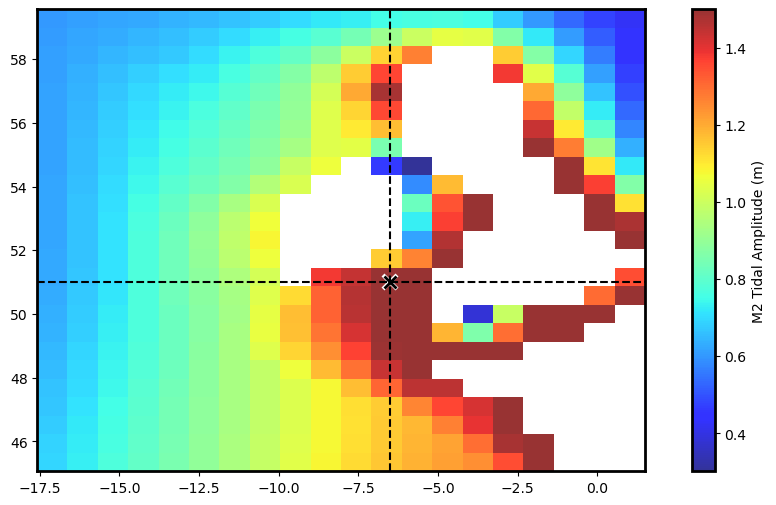

In [70]:
# plot to show the point you are studying and make sure that it is correct. Remember that if the tile is from 6 to 12 you need to rotate it.
# Remember also to activate the option to change your longitudes ticks if you are in tiles close to dateline otherwise it will not plot correctly
data = da.isel(tile=2, i = slice(20,40), j =slice(40, 65)).where(da.isel(tile=2)!=0)
plt.figure(figsize=(12,6))
lon_im = ds_anom.XC.isel(tile=2, i=slice(20, 40), j=slice(40, 65))
lat_im = ds_anom.YC.isel(tile=2, i=slice(20, 40), j=slice(40, 65))
#lon_im = (lon_im + 360) % 360
plt.imshow(data, vmax=1.5, cmap='jet', origin='lower', #np.rot90(data)
           extent=[lon_im.min(), lon_im.max(), lat_im.min(), lat_im.max()], alpha=0.8)
cbar = plt.colorbar()
cbar.set_label('M2 Tidal Amplitude (m)')

plt.plot(lon, lat, marker='x', color='white', markersize=10, markeredgewidth=3)
plt.plot(lon, lat, marker='x', color='black', markersize=8, markeredgewidth=2)

plt.axvline(x=lon, color='black', linestyle='--', linewidth=1.5)
plt.axhline(y=lat, color='black', linestyle='--', linewidth=1.5)

In [69]:
amp_fit, phase_fit = constants(
    t=t,
    ht=ht_mod,
    constituents=constituents,
    deltat=0.0,
    corrections='OTIS',
    solver='lstsq'
)

In [71]:
amp,ph,D,c = pyTMD.io.OTIS.extract_constants(lon, lat, model.grid_file, model.model_file, 4326,
    type='z',
    method='spline',
    grid='OTIS')

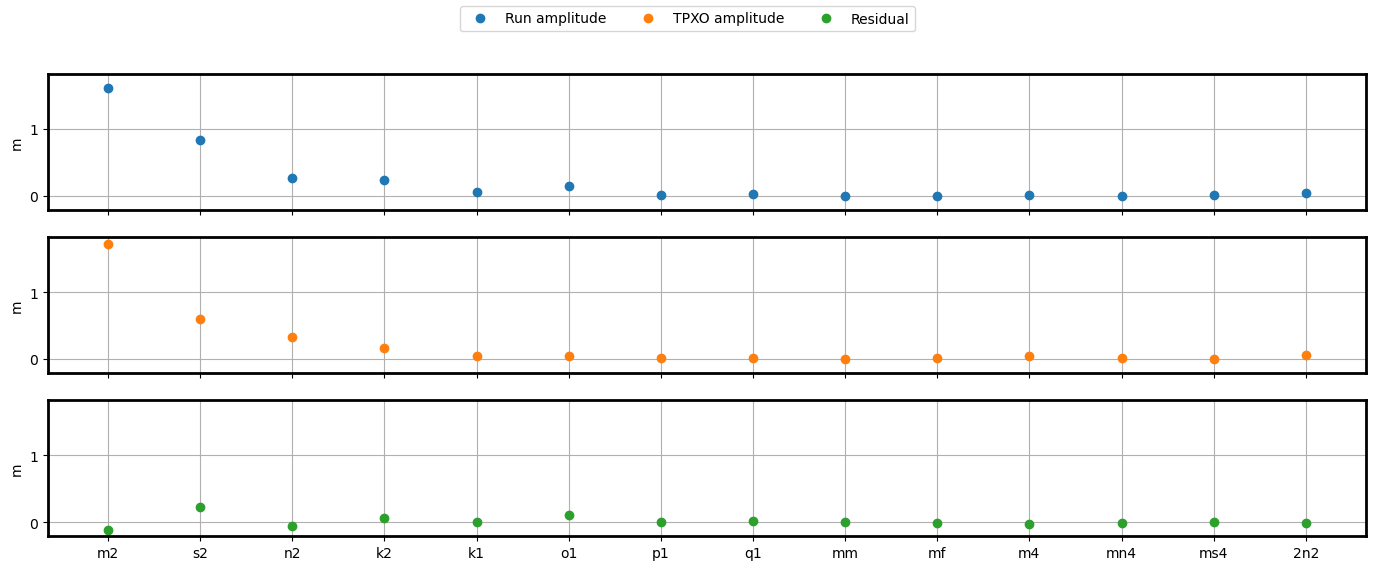

In [72]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(constituents, amp_fit, label="Run amplitude", color="C0", marker = "o", linestyle = "None")
ax1.plot(constituents, amp.data[0][:14], label="TPXO amplitude", color="C1", marker = "o", linestyle = "None")
ax2.plot(constituents,  amp_fit - amp.data[0][:14], label="Residual", color="C2", marker = "o", linestyle = "None")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=3, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()

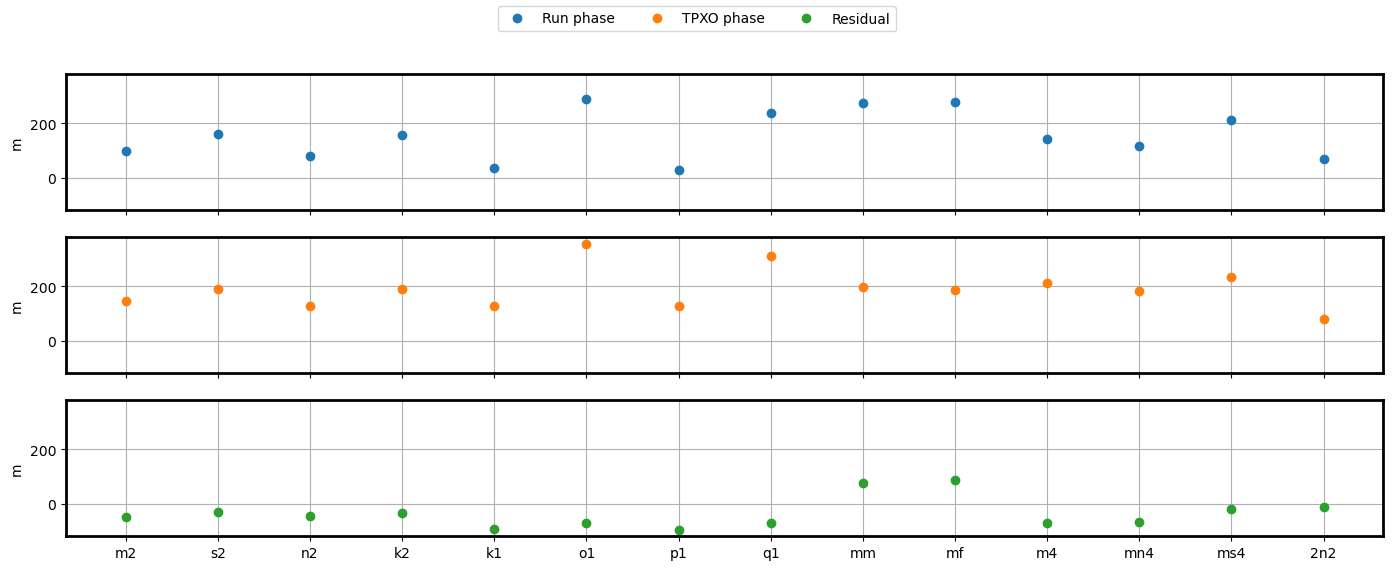

In [73]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(constituents,  phase_fit, label="Run phase", color="C0", marker = "o", linestyle = "None")
ax1.plot(constituents, ph.data[0][:14], label="TPXO phase", color="C1", marker = "o", linestyle = "None")
ax2.plot(constituents,  phase_fit - ph.data[0][:14], label="Residual", color="C2", marker = "o", linestyle = "None")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=3, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()

# NEW ZELAND

In [37]:
ht_mod = ds_anom.isel(tile=8, i=62, j=30).ETAN.values

In [38]:
lon = ds_anom.isel(tile=8, i=62, j=30).XC.values
lat = ds_anom.isel(tile=8, i=62, j=30).YC.values
print(lat, lon)

-39.159897 172.5


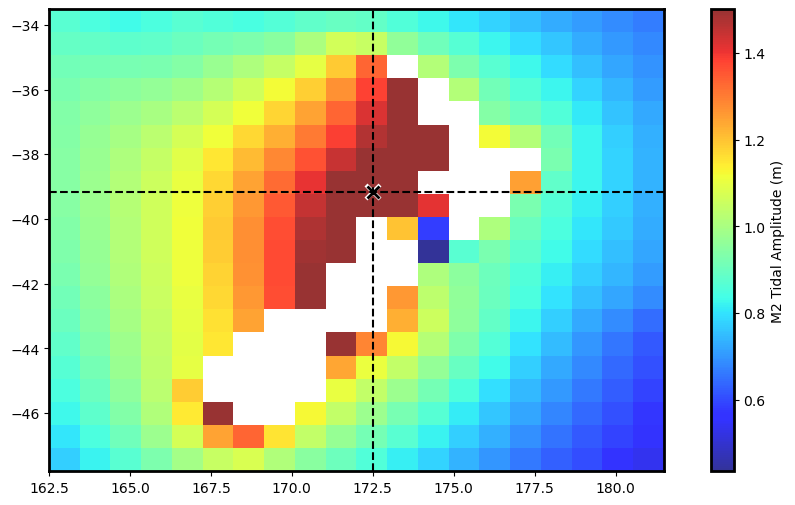

In [21]:
data = da.isel(tile=8, i= slice(55, 75), j = slice(20, 40)).where(da.isel(tile=8)!=0)
plt.figure(figsize=(12,6))
lon_im = ds_anom.XC.isel(tile=8, i=slice(55, 75), j=slice(20, 40))
lat_im = ds_anom.YC.isel(tile=8, i=slice(55, 75), j=slice(20, 40))
lon_im = (lon_im + 360) % 360
plt.imshow(np.rot90(data), vmax=1.5, cmap='jet', origin='lower', 
           extent=[lon_im.min(), lon_im.max(), lat_im.min(), lat_im.max()], alpha=0.8)
cbar = plt.colorbar()
cbar.set_label('M2 Tidal Amplitude (m)')

plt.plot(lon, lat, marker='x', color='white', markersize=10, markeredgewidth=3)
plt.plot(lon, lat, marker='x', color='black', markersize=8, markeredgewidth=2)

plt.axvline(x=lon, color='black', linestyle='--', linewidth=1.5)
plt.axhline(y=lat, color='black', linestyle='--', linewidth=1.5)

In [39]:
amp_fit, phase_fit = constants(
    t=t,
    ht=ht_mod,
    constituents=constituents,
    deltat=0.0,
    corrections='OTIS',
    solver='lstsq'
)

In [40]:
amp,ph,D,c = pyTMD.io.OTIS.extract_constants(lon, lat, model.grid_file, model.model_file, 4326,
    type='z',
    method='spline',
    grid='OTIS')

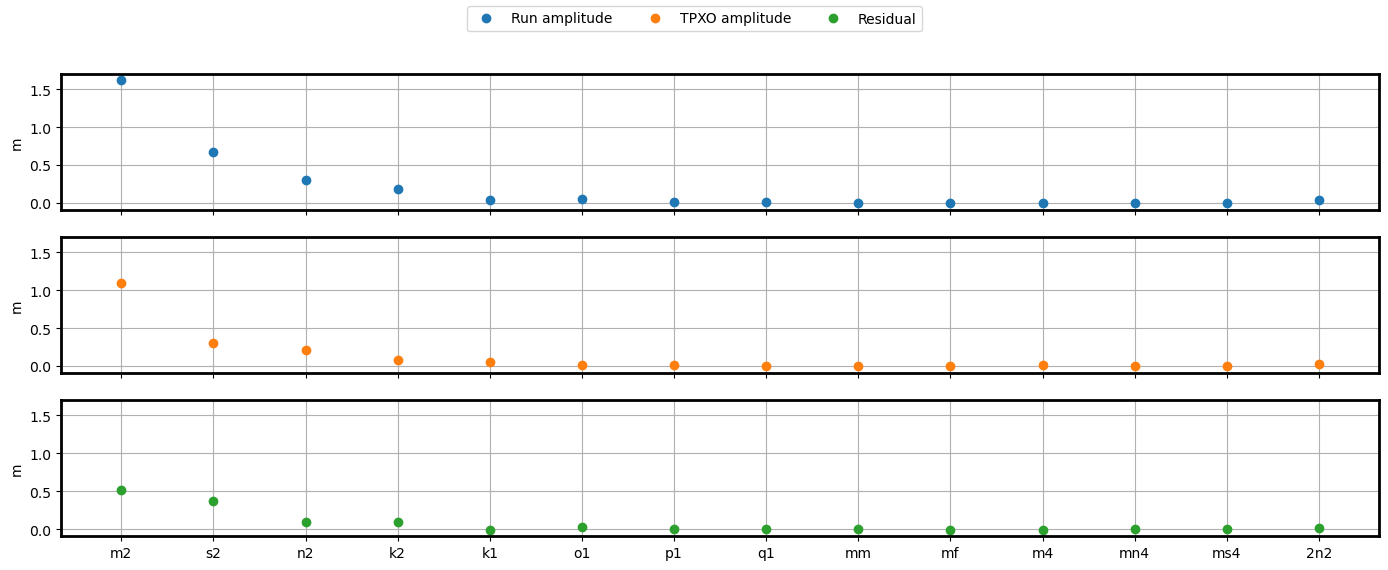

In [41]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(constituents, amp_fit, label="Run amplitude", color="C0", marker = "o", linestyle = "None")
ax1.plot(constituents, amp.data[0][:14], label="TPXO amplitude", color="C1", marker = "o", linestyle = "None")
ax2.plot(constituents,  amp_fit - amp.data[0][:14], label="Residual", color="C2", marker = "o", linestyle = "None")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=3, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()

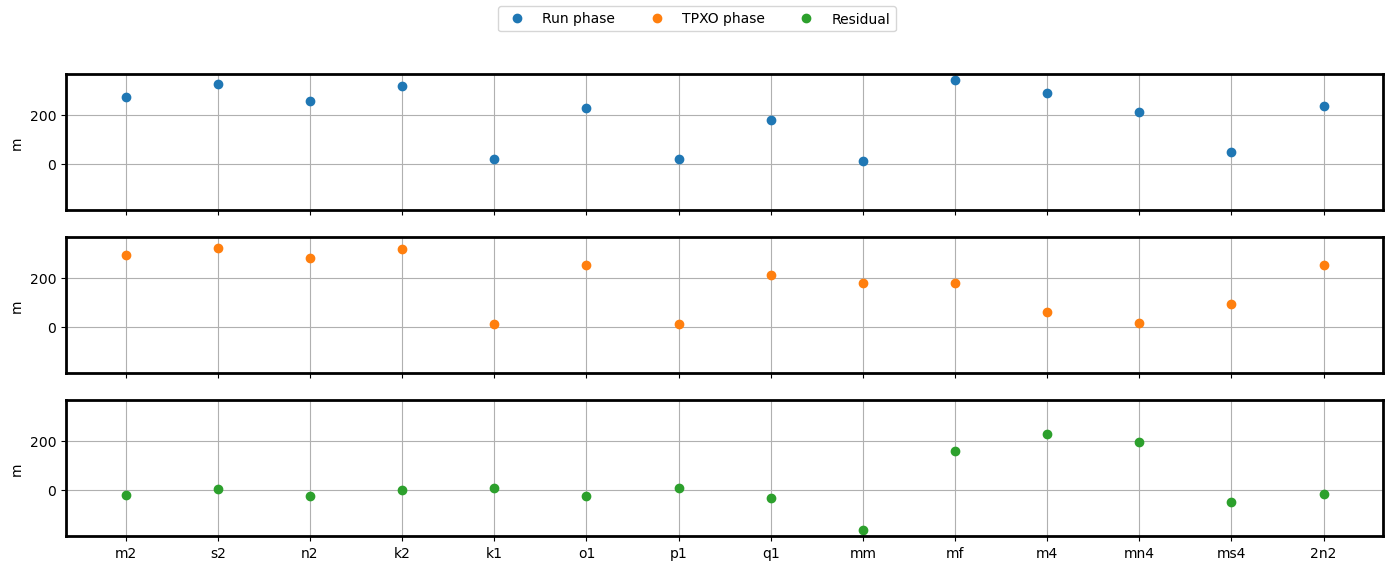

In [42]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(constituents,  phase_fit, label="Run phase", color="C0", marker = "o", linestyle = "None")
ax1.plot(constituents, ph.data[0][:14], label="TPXO phase", color="C1", marker = "o", linestyle = "None")
ax2.plot(constituents,  phase_fit - ph.data[0][:14], label="Residual", color="C2", marker = "o", linestyle = "None")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=3, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()

# FUNDY BAY

In [37]:
ht_mod = ds_anom.isel(tile=10, i=21, j=58).ETAN.values

In [35]:
lon = ds_anom.isel(tile=10, i=21, j=58).XC.values
lat = ds_anom.isel(tile=10, i=21, j=58).YC.values
print(lat, lon)

61.624043 -69.30568


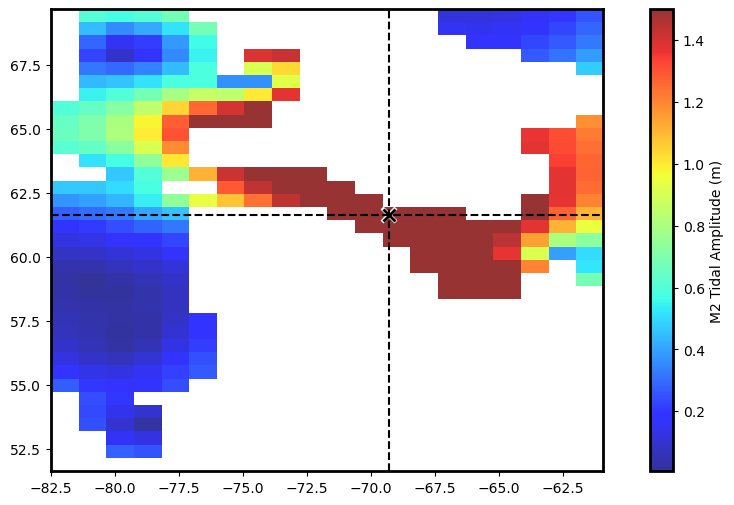

In [36]:
data = da.isel(tile=10, i= slice(5, 40), j = slice(45, 65)).where(da.isel(tile=10)!=0)
plt.figure(figsize=(12,6))
lon_im = ds_anom.XC.isel(tile=10, i= slice(5, 40), j = slice(45, 65))
lat_im = ds_anom.YC.isel(tile=10, i= slice(5, 40), j = slice(45, 65))
plt.imshow(np.rot90(data), vmax=1.5, cmap='jet', origin='lower', 
           extent=[lon_im.min(), lon_im.max(), lat_im.min(), lat_im.max()], alpha=0.8)
cbar = plt.colorbar()
cbar.set_label('M2 Tidal Amplitude (m)')

plt.plot(lon, lat, marker='x', color='white', markersize=10, markeredgewidth=3)
plt.plot(lon, lat, marker='x', color='black', markersize=8, markeredgewidth=2)

plt.axvline(x=lon, color='black', linestyle='--', linewidth=1.5)
plt.axhline(y=lat, color='black', linestyle='--', linewidth=1.5)

In [38]:
amp_fit, phase_fit = constants(
    t=t,
    ht=ht_mod,
    constituents=constituents,
    deltat=0.0,
    corrections='OTIS',
    solver='lstsq'
)

In [39]:
amp,ph,D,c = pyTMD.io.OTIS.extract_constants(lon, lat, model.grid_file, model.model_file, 4326,
    type='z',
    method='spline',
    grid='OTIS')

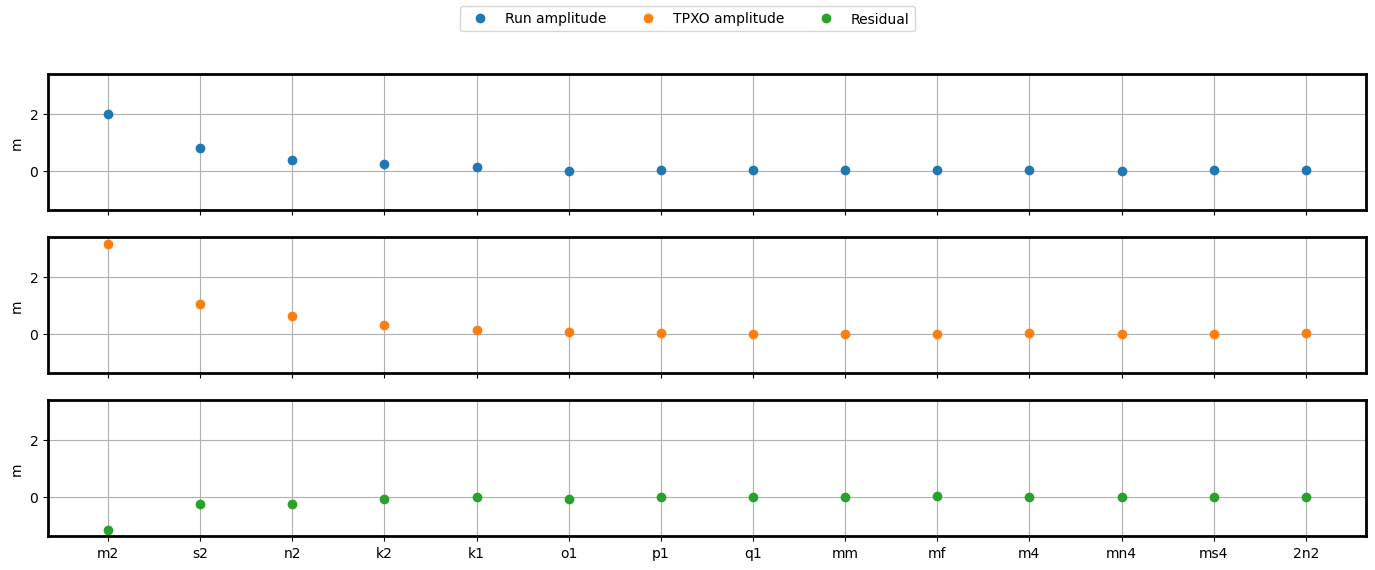

In [40]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(constituents, amp_fit, label="Run amplitude", color="C0", marker = "o", linestyle = "None")
ax1.plot(constituents, amp.data[0][:14], label="TPXO amplitude", color="C1", marker = "o", linestyle = "None")
ax2.plot(constituents,  amp_fit - amp.data[0][:14], label="Residual", color="C2", marker = "o", linestyle = "None")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=3, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()

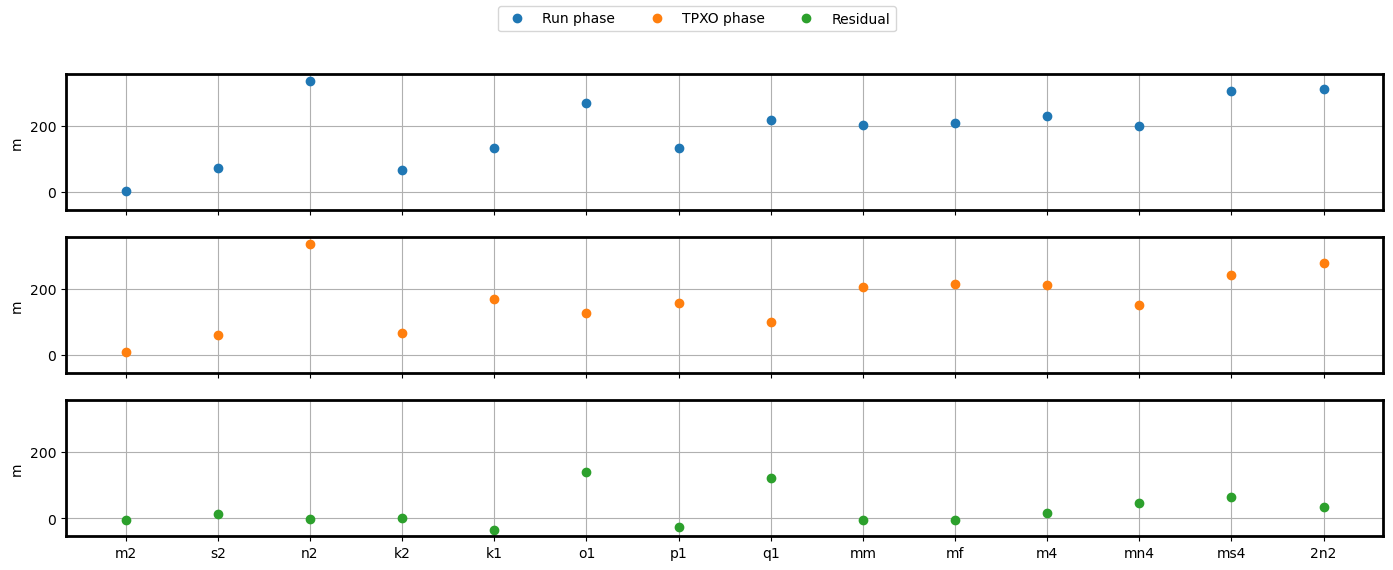

In [41]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(constituents,  phase_fit, label="Run phase", color="C0", marker = "o", linestyle = "None")
ax1.plot(constituents, ph.data[0][:14], label="TPXO phase", color="C1", marker = "o", linestyle = "None")
ax2.plot(constituents,  phase_fit - ph.data[0][:14], label="Residual", color="C2", marker = "o", linestyle = "None")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=3, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()